In [1]:
import pandas as pd
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


How many taxi trips are reported in the original file?

In [2]:
%%bash
SOURCE_FILE=https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-12.csv
if [ ! -f yellow_tripdata_2016-12.csv ]; then 
    echo "Pas trouvé le fichier global, téléchargement...";
    wget $SOURCE_FILE
else
    echo "Trouvé, on s'assure que le fichier est complet...";
    wget -c $SOURCE_FILE
fi



Trouvé, on s'assure que le fichier est complet...


--2018-11-01 22:13:22--  https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-12.csv
Résolution de s3.amazonaws.com (s3.amazonaws.com)… 54.231.114.178
Connexion à s3.amazonaws.com (s3.amazonaws.com)|54.231.114.178|:443… connecté.
requête HTTP transmise, en attente de la réponse… 416 Requested Range Not Satisfiable

    Le fichier a déjà été complètement récupéré ; rien à faire.



In [3]:
%%sh
wc -l yellow_tripdata_2016-12.csv 

10449409 yellow_tripdata_2016-12.csv


Getting random samples:

In [4]:
%%sh
head -n 1 yellow_tripdata_2016-12.csv > sample100.csv
tail -n +2 yellow_tripdata_2016-12.csv | shuf -n 100 | sed 's/,,//g' >> sample100.csv

In [5]:
sample100 = pd.read_csv('sample100.csv', parse_dates=[1,2])
sample100.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-12-31 20:28:20,2016-12-31 20:34:42,1,0.40,1,N,162,161,1,5.5,0.5,0.5,2.0,0.0,0.3,8.8
1,1,2016-12-14 05:46:42,2016-12-14 06:02:16,1,4.60,1,N,263,226,2,16.0,0.5,0.5,0.0,0.0,0.3,17.3
2,2,2016-12-25 20:58:22,2016-12-25 21:11:27,2,2.25,1,N,107,100,2,11.0,0.5,0.5,0.0,0.0,0.3,12.3
3,2,2016-12-03 23:34:29,2016-12-04 00:04:16,1,3.29,1,N,68,229,2,19.5,0.5,0.5,0.0,0.0,0.3,20.8
4,2,2016-12-22 22:24:37,2016-12-22 22:37:58,1,1.36,1,N,50,186,2,9.5,0.5,0.5,0.0,0.0,0.3,10.8


## Estimating the proportion of tippers

In [6]:
is_tipped = sample100.tip_amount>0
is_tipped.mean()

0.64

Standard deviation:

In [7]:
ph = is_tipped.mean()
s = np.sqrt(ph * (1-ph) / len(is_tipped))
s

0.048

95% confidence interval:

In [8]:
from statsmodels.stats.proportion import proportion_confint
proportion_confint(sum(is_tipped), len(is_tipped), alpha=0.05)

(0.5459217287420775, 0.7340782712579226)

Pretty wide! How big do we need a sample for the 95% confidence interval to be approximately 2% wide?

In [9]:
from statsmodels.stats.proportion import samplesize_confint_proportion
int(np.ceil(samplesize_confint_proportion(ph, 0.01)))

8851

Let's take a bigger sample:

In [10]:
%%sh
head -n 1 yellow_tripdata_2016-12.csv > sample10000.csv
tail -n +2 yellow_tripdata_2016-12.csv | shuf -n 10000 | sed 's/,,//g' >> sample10000.csv

In [11]:
sample10000 = pd.read_csv('sample10000.csv', parse_dates=[1,2])
is_tipped = sample10000.tip_amount>0
is_tipped.mean()

0.6172

In [12]:
ph = is_tipped.mean()
s = np.sqrt(ph * (1-ph) / len(is_tipped))
s

0.004860701183985701

In [13]:
proportion_confint(sum(is_tipped), len(is_tipped), alpha=0.05)

(0.6076732007397768, 0.6267267992602231)

It is indeed about 2% wide. 

## Estimating the average trip duration

In [14]:
sample100['duration'] = [x.total_seconds() / 60 for x in sample100.tpep_dropoff_datetime -  sample100.tpep_pickup_datetime]

In [15]:
sample100['duration'].mean() 

29.452

In [16]:
s = sample100['duration'].std(ddof=1) / np.sqrt(len(sample100['duration']))
s

14.302039242807501

In [17]:
from statsmodels.stats.weightstats import _tconfint_generic
_tconfint_generic(sample100['duration'].mean(), 
                  s, 
                  len(sample100['duration']) - 1, 
                  0.05, 'two-sided')

(1.073651293278953, 57.830348706721054)

/usr/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4ad6cb4450>]],
      dtype=object)

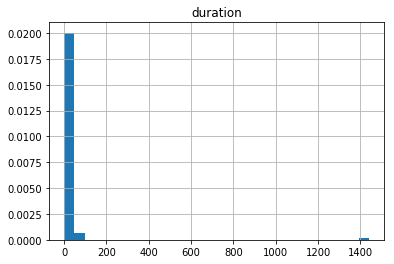

In [18]:
sample100.hist(column = 'duration', bins=30, normed=True)

In [19]:
sample10000['duration'] = [x.total_seconds() / 60 for x in sample10000.tpep_dropoff_datetime -  sample10000.tpep_pickup_datetime]

In [20]:
sample10000['duration'].mean()

17.028693333333337

In [21]:
s = sample10000['duration'].std(ddof=1) / np.sqrt(len(sample10000['duration']))
s

0.5878773161589573

In [22]:
_tconfint_generic(sample10000['duration'].mean(), 
                  s, 
                  len(sample10000['duration']) - 1, 
                  0.05, 'two-sided')

(15.876335475344217, 18.181051191322457)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4ad6b9d250>]],
      dtype=object)

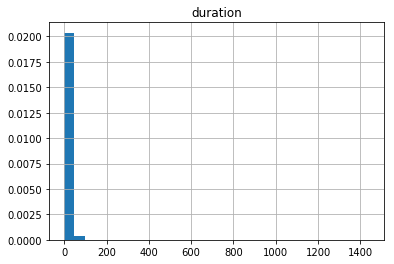

In [23]:
sample10000.hist(column = 'duration', bins=30, normed=True)

In [24]:
tmp = sample10000['duration'] < 120
tmp.value_counts()

True     9980
False      20
Name: duration, dtype: int64

14.566068804275217

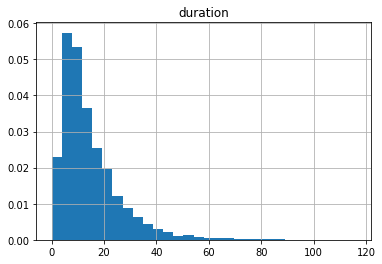

In [25]:
sample10000[sample10000['duration'] < 120].hist(column = 'duration', bins=30, normed=True)
sample10000['duration'][sample10000['duration'] < 120].mean()

In [26]:
sample100['duration'].median()

12.25

In [27]:
sample10000['duration'].median()

11.25

In [28]:
sample10000['duration'][sample10000['duration'] < 120].median()

11.216666666666667

Bootstrap:

In [40]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
    
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [41]:
median_duration = list(map(np.median, get_bootstrap_samples(sample100['duration'].values, 1000)))
stat_intervals(median_duration, 0.05)

array([ 9.73333333, 13.91666667])

In [42]:
median_duration = list(map(np.median, get_bootstrap_samples(sample10000['duration'].values, 1000)))
stat_intervals(median_duration, 0.05)

array([11.03333333, 11.43333333])